# Hands-on session: Machine Learning & Data Visualization
---
## 3 - Evaluating ML models
---


How do I use this?

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sina-mansour/OHBM-Brainhack-2021/blob/main/notebooks/03_model_evaluation.ipynb) | [![View the notebook](https://img.shields.io/badge/render-nbviewer-orange.svg)](https://nbviewer.jupyter.org/github/sina-mansour/OHBM-Brainhack-2021/blob/main/notebooks/03_model_evaluation.ipynb?flush_cache=true)

---

package installation for google colab:

In [ ]:
# install required packages for colab
!wget "https://raw.githubusercontent.com/sina-mansour/OHBM-Brainhack-2021/main/colab/requirements.txt" && pip install -r requirements.txt


---

Loading packages

In [1]:
# pandas for data handling
import pandas as pd

# matplotlib and seaborn for data visualization
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# setup inline plotting for jupyter
%matplotlib inline

# numpy for mathematical operations of data
import numpy as np

# nilearn and nibabel for handling neuroimaging data
import nilearn.datasets as nidata
import nilearn.plotting as niplot
import nibabel as nib

# sklearn is python's base of operations for everything ML
import sklearn

# statsmodels is more of an statistical inference toolbox for python
import statsmodels



---

So far we've talked about basic steps in fitting a machine learning model. We now know how to use the abilities of sklearn to extract predictions from the sample using supervised and unsupervised approaches.

Now, the next big question down the line is how do we evaluate our models. How can we tell if our trained model is doing OK!

We'd ideally want to have a set of concise methods to measure model performance, and that's what we'll cover in this section.

## Evaluation of regression models

Recall that in previous section, we used two different regression models to predict brain age from neuroimaging data. Here we'll try to evaluate the performance of these models.

First, we should run the following few cells to redo all that was covered in the previous section, (to load the data and fit the models)

In [3]:
# load the data from file
data = pd.read_csv('https://raw.githubusercontent.com/sina-mansour/OHBM-Brainhack-2021/main/data/abide2.tsv', sep='\t')

# The filter() method allows us to select variables by name--
# in this case, we put all features that match 'fs' in X_all.
X_all = data.filter(like='fs')

# for the sake of simplicity we'll only use a portion of the whole feature set
N_FEATURES = 5

# pandas DFs have a helpful sample() method for sampling rows/columns
X_sample = X_all.sample(N_FEATURES, axis=1, random_state=100)

# Split feature set with a fixed random seed for reproducibility
X_sample_train, X_sample_test = sklearn.model_selection.train_test_split(X_sample, test_size=200, random_state=123)
X_all_train, X_all_test = sklearn.model_selection.train_test_split(X_all, test_size=200, random_state=123)

# Split the demographic information
age = data['age']
sex = data['sex']
group = data['group']

age_train, age_test = sklearn.model_selection.train_test_split(age, test_size=200, random_state=123)
sex_train, sex_test = sklearn.model_selection.train_test_split(sex, test_size=200, random_state=123)
group_train, group_test = sklearn.model_selection.train_test_split(group, test_size=200, random_state=123)


Next, let's fit the linear regression and the support vector regression models to predict age from five randomly selected neuroimaging measures.

In [4]:
# linear regression
linear = sklearn.linear_model.LinearRegression()
linear.fit(X_sample_train, age_train)
age_test_predicted_linear = linear.predict(X_sample_test)

# SVR with rbf kernel
svr = sklearn.svm.SVR()
svr.fit(X_sample_train, age_train)
age_test_predicted_svr = svr.predict(X_sample_test)



Let's have a visual inspection of the fit:

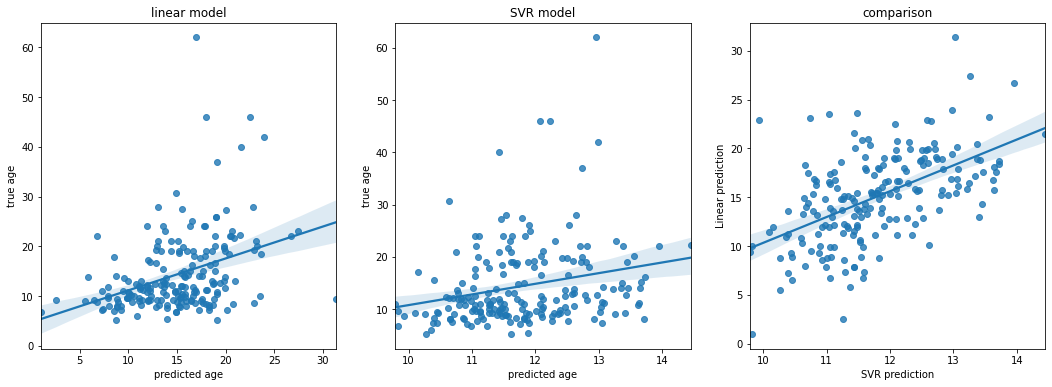

In [9]:
# create a figure
fig, axes = plt.subplots(ncols=3, figsize=(18, 6))

# scatter brain data vs. age
sns.regplot(x=age_test_predicted_linear, y=age_test, ax=axes[0])
axes[0].set_xlabel('predicted age')
axes[0].set_ylabel('true age')
axes[0].set_title('linear model')

sns.regplot(x=age_test_predicted_svr, y=age_test, ax=axes[1])
axes[1].set_xlabel('predicted age')
axes[1].set_ylabel('true age')
axes[1].set_title('SVR model')

sns.regplot(x=age_test_predicted_svr, y=age_test_predicted_linear, ax=axes[2])
axes[2].set_xlabel('SVR prediction')
axes[2].set_ylabel('Linear prediction')
axes[2].set_title('comparison');



In [15]:
linear.score(X_sample_test, age_test)

0.09015736254540774

In [16]:
svr.score(X_sample_test, age_test)

-0.06641437035320341

### Evaluation metrics

There are many metrics we could use to quantify the quality of the predictions our model generates. Scikit-learn conveniently packages some of the most commonly used performance metrics in its `metrics` module. As is true of `Estimator` objects, all metrics in scikit-learn follow the same usage pattern: we pass in the true scores and the model's predicted scores, respectively.

#### The coefficient of determination ($R^2$)
Let's see how this works using one of the most commonly used metrics in regression problems: the coefficient of determination, or $R^2$, which quantifies the proportion of variance in the outcome variable (e.g., age) explained by the fitted model. Note that $R^2$ is a relative performance metric—i.e., it tells us how well our model captures the observed *variation* in scores, but it's insensitive to the absolute values (i.e., a model can have an $R^2$ of 1 while generating a predicted score distribution entirely outside the range of the true scores). But for our purposes it'll work fine.

Here's how we apply a metric function from `sklearn.metrics`:


In [10]:
# the metrics module contains predefined scoring functions
# for commonly used metrics like r^2, MSE, etc. but you
# can use any function you like as long as it has the
# signature used in the r2_score call below
from sklearn.metrics import r2_score

# scoring functions are called by passing an array of
# true scores and and an array of predicted scores as
# inputs
print('R^2 score of the linear model', r2_score(age_test, age_test_predicted_linear))
print('R^2 score of the svr model', r2_score(age_test, age_test_predicted_svr))


R^2 score of the linear model 0.09015736254540774
R^2 score of the svr model -0.06641437035320341


Given how easy it is to use a scoring function, let's go over a few other important scoring methods:

#### Mean Absolute Error

Mean Squared Error, or MSE for short, is a popular error metric for regression problems. It is also an important loss function for algorithms fit or optimized using the least squares framing of a regression problem. The MSE is calculated as the mean or average of the squared differences between predicted and expected target values in a dataset.

The squaring also has the effect of magnifying large errors. Hence, the larger the difference between the predicted and expected values, the larger the resulting error. This has the effect of “punishing” models more for larger errors when MSE is used as a loss function. It also has the effect of “punishing” models by inflating the average error score when used as a metric.


In [11]:
# the metrics module contains predefined scoring functions
# for commonly used metrics like r^2, MSE, etc. but you
# can use any function you like as long as it has the
# signature used in the r2_score call below
from sklearn.metrics import mean_squared_error

# scoring functions are called by passing an array of
# true scores and and an array of predicted scores as
# inputs
print('R^2 score of the linear model', mean_squared_error(age_test, age_test_predicted_linear))
print('R^2 score of the svr model', mean_squared_error(age_test, age_test_predicted_svr))


R^2 score of the linear model 56.27052742581614
R^2 score of the svr model 65.95393159648359


#### Root Mean Squared Error

The Root Mean Squared Error, or RMSE, is an extension of the mean squared error.

Importantly, the square root of the error is calculated, which means that the units of the RMSE are the same as the original units of the target value that is being predicted.

As such, it may be common to use MSE loss to train a regression predictive model, and to use RMSE to evaluate and report its performance.


In [12]:
# the metrics module contains predefined scoring functions
# for commonly used metrics like r^2, MSE, etc. but you
# can use any function you like as long as it has the
# signature used in the r2_score call below
from sklearn.metrics import mean_squared_error

# scoring functions are called by passing an array of
# true scores and and an array of predicted scores as
# inputs
print('R^2 score of the linear model', mean_squared_error(age_test, age_test_predicted_linear, squared=False))
print('R^2 score of the svr model', mean_squared_error(age_test, age_test_predicted_svr, squared=False))


R^2 score of the linear model 7.501368370225271
R^2 score of the svr model 8.121202595458605



Feel free to check other useful evaluation metrics from [`sklearn.metrics`](https://scikit-learn.org/stable/modules/model_evaluation.html).

---

## Evaluation of classification models

In the previous section we used a classifier to predict diagnosis from imaging data:

In [19]:
# use the naive bayes classifier to predict autism vs. control
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(X_all_train, group_train)
predicted_group_test = gnb.predict(X_all_test)



We already know how to obtain a performance estimate from the built-in scorer, so let's do that:

In [22]:
gnb.score(X_all_test, group_test)

0.585

In this case, the default scoring metric is just overall accuracy (i.e., the proportion of all samples that were assigned to the correct class). Is 63% accuracy good or bad? As always, it depends. It's obviously nowhere near good enough to be useful in practical applications, but on the other hand, it's clearly better than randomly guessing.

#### Classification reports
The raw accuracy score is a good place to start, but it often masks important nuances. We can get some more information using the `classification_report` utility, which breaks down classification performance into separate `precision` (aka positive predictive value), `recall` (aka sensitivity), and `f1` scores (we can also get these individually from the `sklearn.metrics` module, as well as a number of other useful utilities).


In [20]:
from sklearn.metrics import classification_report

print(classification_report(group_test, predicted_group_test))

              precision    recall  f1-score   support

         1.0       0.69      0.42      0.52       108
         2.0       0.53      0.78      0.63        92

    accuracy                           0.58       200
   macro avg       0.61      0.60      0.58       200
weighted avg       0.62      0.58      0.57       200



#### The classification confusion matrix:

This matrix provides the main sets of possibilities in a binary classification problem.


|               | Positive Prediction | Negative Prediction |
|---|---|---|
|Positive Class | True Positive (TP)  | False Negative (FN) |
|Negative Class | False Positive (FP) | True Negative (TN) |

Many main metrics for evaluation of classification problems are just merely an extension of the confusion matrix:

- Sensitivity (also known as recall) is: TruePositive / (TruePositive + FalseNegative)

- Specificity = TrueNegative / (FalsePositive + TrueNegative)

- Precision = TruePositive / (TruePositive + FalsePositive)

- Recall = TruePositive / (TruePositive + FalseNegative)

- F-Measure = (2 * Precision * Recall) / (Precision + Recall)


---

At the end of this section, we now know how to fit *and* **Evaluate** a machine learning model in Python.

The next step is to familiarize ourselves with some of the most important practices that should be implemented in machine learning pipelines.